# Unet in Tensorflow

In [48]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output

from data import load_data, tf_dataset

## Load Data

In [7]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

N_CLASSES = 2
OUTPUT_SIZE = (128, 128)
BATCH_SIZE = 8
BUFFER_SIZE = 1000
TRAIN_LENGTH = len(train_x)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

## Preprocessing

In [10]:
train_dataset = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE)

## Show Images

In [27]:
def display_images(image, mask, prediction=None):
    num_subplots = 2 if prediction is None else 3
    fig, ax = plt.subplots(1, num_subplots, figsize=(15, 15))

    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(image))
    ax[0].set_title('Input Image')

    # One hot mask to single
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(mask))
    ax[1].set_title('True Mask')

    if prediction is not None:
        ax[2].imshow(tf.keras.preprocessing.image.array_to_img(prediction))
        ax[2].set_title('Predicted Mask')
        
    
    plt.axis('off')
    plt.show()


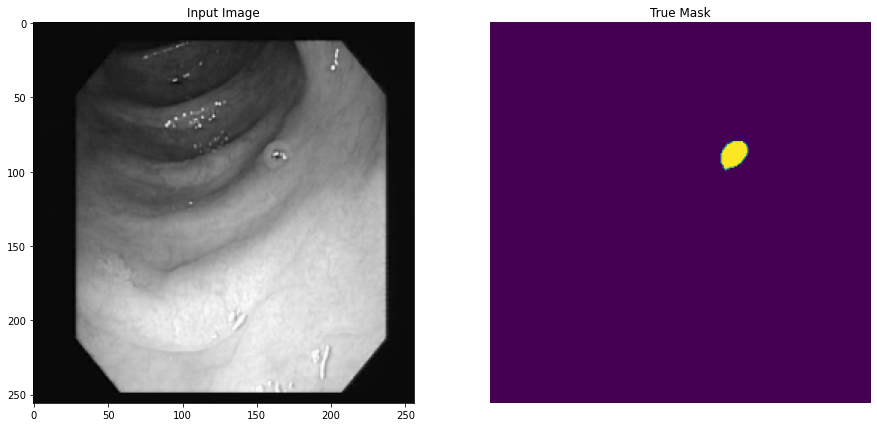

In [19]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
display_images(sample_image, sample_mask)

## Model

In [21]:
from models.tensorflow.unet import UNet

In [44]:
OUTPUT_CHANNELS = 1

lr = 1e-4
opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

model = UNet(out_channels=1)
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=metrics)

In [45]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images(
                image[0],
                mask[0],
                create_mask(pred_mask)
            )
    else:
        pred = model.predict(sample_image[tf.newaxis, ...])
        pred = tf.squeeze(pred, axis=0)
        display_images(
            sample_image, 
            sample_mask,
            pred
        )

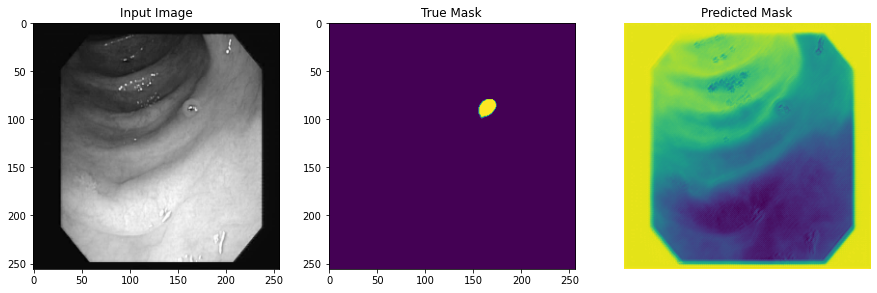

In [46]:
show_predictions()

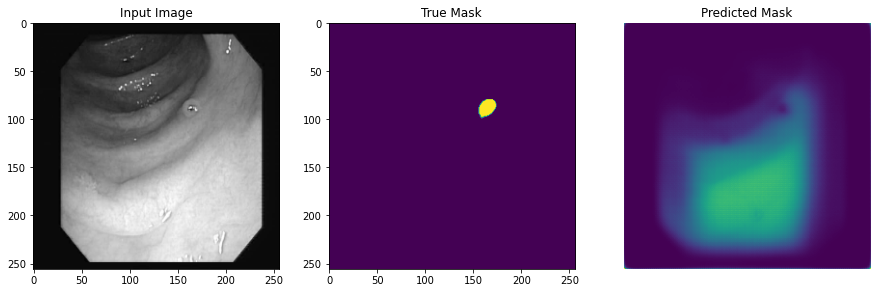


Sample Prediction after epoch 1

Epoch 2/5


KeyboardInterrupt: 

In [51]:


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 5
TRAIN_STEPS = len(train_x)//BATCH_SIZE
VALID_STEPS = len(valid_x)//BATCH_SIZE

if len(train_x) % BATCH_SIZE != 0:
    TRAIN_STEPS += 1
if len(valid_x) % BATCH_SIZE != 0:
    VALID_STEPS += 1

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=TRAIN_STEPS,
                          validation_steps=VALID_STEPS,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])